In [1]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [2]:
from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance

env_name='CartPole-v0'

# Training loop for OPPO
from OPPO import baseline_1, OPPO_update
from Train_policy_func import Policy, device

lr_oppo = 0.01

# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo   = gym.make(env_name)
policy_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
policy_oppo.load_state_dict(torch.load("pi_oppo_final.pth"))
opt_oppo    = torch.optim.Adam(policy_oppo.parameters(), lr=lr_oppo)

# ── Hyperparams for OPPO ──
n_episodes = 1200      # keep same “number of iterations” for fair comparison
max_t      = 200  # cap on steps per episode
print_every=100
gamma=0.99
# ── Run the OPPO training ──
# scores_oppo = OPPO_update(
#     policy       = policy_oppo,
#     optimizer    = opt_oppo,
#     env          = env_oppo,
#     baseline     = baseline_1,
#     n_episodes   = n_episodes,
#     max_t        = max_t,
#     gamma        = gamma,      # you can reuse your PPO γ
#     print_every  = print_every,
#     early_stop   = False
# )

# # ── Post-processing: smooth or average returns per “block” if you like
# avg_scores_oppo = [
#     np.mean(scores_oppo[i : i + print_every])
#     for i in range(0, len(scores_oppo), print_every)
# ]

c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\youss\AppData\Local\Temp\ipykernel_23640\1813812672.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `Tr

In [44]:
lr_oppo = 0.005

# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo2   = gym.make(env_name)
policy_oppo2 = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
#policy_oppo2.load_state_dict(torch.load("pi_oppo2_final.pth"))
opt_oppo2    = torch.optim.Adam(policy_oppo2.parameters(), lr=lr_oppo)

# ── Hyperparams for OPPO ──
n_episodes = 100      # keep same “number of iterations” for fair comparison
max_t      = 200  # cap on steps per episode
print_every=100
gamma=0.99
#── Run the OPPO training ──
scores_oppo2 = OPPO_update(
    policy       = policy_oppo2,
    optimizer    = opt_oppo2,
    env          = env_oppo2,
    baseline     = baseline_1,
    n_episodes   = n_episodes,
    max_t        = max_t,
    gamma        = gamma,      # you can reuse your PPO γ
    print_every  = print_every,
    early_stop   = True
)

#── Post-processing: smooth or average returns per “block” if you like
avg_scores_oppo2 = [
    np.mean(scores_oppo2[i : i + print_every])
    for i in range(0, len(scores_oppo2), print_every)
]

100%|██████████| 100/100 [00:01<00:00, 61.49it/s]

Episode 100 	 Average Score over the last 100 episodes: 25.9


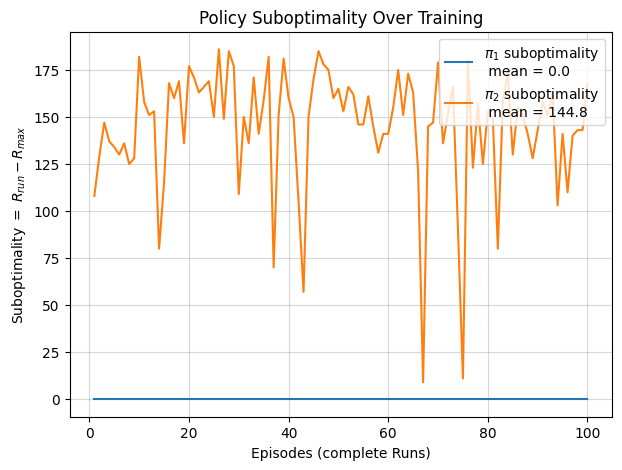

In [45]:
from PPO import ppo_update, RolloutBuffer, evaluate_policy

num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(policy_oppo, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(policy_oppo2, env_oppo, n_episodes=num_episodes)

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    200,
)  # in cartpole, 200 is the maximum reward

In [46]:
from pairs_generator import sample_preference_pairs
traj1 = generate_trajectory(policy_oppo, env_oppo, max_steps=1000)
traj2 = generate_trajectory(policy_oppo2, env_oppo2, max_steps=1000)

print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")

prefs = sample_preference_pairs(policy_oppo, policy_oppo2, env_oppo, K=300) # Need to define K elsewhere as hyperparameter
print(f"Collected {len(prefs)} preference pairs.")

π₁ → length 200, total reward 200.0
π₂ → length 28, total reward 28.0
Collected 300 preference pairs.


In [ ]:
from RLHF import RewardModel, train_reward_model
from pairs_generator import compute_reward_from_traj

reward_model=RewardModel(state_dim=env_oppo.observation_space.shape[0],
                     action_dim=env_oppo.action_space.n).to(device)
lr_reward=0.01
opt_reward=torch.optim.Adam(reward_model.parameters(), lr=lr_reward)

train_reward_model(reward_model,prefs,opt_reward,epochs=50)
total_reward= compute_reward_from_traj(reward_model,traj1)


Epoch 0: Reward model loss = 241.9710
Epoch 1: Reward model loss = 189.7807
Epoch 2: Reward model loss = 182.4749
Epoch 3: Reward model loss = 177.4931
Epoch 4: Reward model loss = 173.4356
Epoch 5: Reward model loss = 170.0208
Epoch 6: Reward model loss = 167.3202
Epoch 7: Reward model loss = 165.0459
Epoch 8: Reward model loss = 163.1182
Epoch 9: Reward model loss = 161.4058
Epoch 10: Reward model loss = 159.8441
Epoch 11: Reward model loss = 158.4764
Epoch 12: Reward model loss = 157.1495
Epoch 13: Reward model loss = 155.9712
Epoch 14: Reward model loss = 154.9214
Epoch 15: Reward model loss = 153.8930
Epoch 16: Reward model loss = 152.9785
Epoch 17: Reward model loss = 152.0705
Epoch 18: Reward model loss = 151.2600
Epoch 19: Reward model loss = 150.4519
Epoch 20: Reward model loss = 149.6649
Epoch 21: Reward model loss = 148.8697
Epoch 22: Reward model loss = 148.1570
Epoch 23: Reward model loss = 147.4714
Epoch 24: Reward model loss = 146.8759
Epoch 25: Reward model loss = 146.3

In [49]:
correct = 0
for pair in prefs:
    r_pos = compute_reward_from_traj(reward_model, pair["traj_acc"])
    r_neg = compute_reward_from_traj(reward_model, pair["traj_rej"])
    if r_pos > r_neg:
        correct += 1
accuracy = correct / len(prefs)
print(f"Reward model ranking accuracy: {accuracy:.2f}")

torch.save(reward_model.state_dict(), f"reward_model_youss.pth")


Reward model ranking accuracy: 0.94
